In [12]:
import gym
import random

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from torch.nn.functional import mse_loss

from torch import optim
import copy
from collections import namedtuple

from itertools import count
import math

import matplotlib.pyplot as plt
%matplotlib inline

# Deep Q Learning Network 

Using a deep Q network to solve the discrete lunar lander challenge. https://gym.openai.com/envs/LunarLander-v2/

Landing pad is always at coordinates (0,0). Coordinates are the first two numbers in state vector. Reward for moving from the top of the screen to landing pad and zero speed is about 100..140 points. If lander moves away from landing pad it loses reward back. Episode finishes if the lander crashes or comes to rest, receiving additional -100 or +100 points. Each leg ground contact is +10. Firing main engine is -0.3 points each frame. Solved is 200 points. Landing outside landing pad is possible. Fuel is infinite, so an agent can learn to fly and then land on its first attempt. Four discrete actions available: do nothing, fire left orientation engine, fire main engine, fire right orientation engine.

Useful references:

https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html

https://towardsdatascience.com/ai-learning-to-land-a-rocket-reinforcement-learning-84d61f97d055

## Hyperparameters

As part of the implementation I would like to investigate a number of the hyperparmeters. 

- epochs

- shape of the network 
     - number of layers
     - no softmax at the end

- learning rate 

- discount factor

- replay buffer size

- batch size

In [13]:
# create the environment and explore the action and observation space.
env = gym.make('LunarLander-v2')

print('Example action {}'.format(env.action_space.sample()))
print('Example observation space {}'.format(env.reset()))

Example action 2
Example observation space [ 7.5206754e-04  1.3987600e+00  7.6157108e-02 -5.4044640e-01
 -8.6463278e-04 -1.7250784e-02  0.0000000e+00  0.0000000e+00]


In [14]:
# Have a look at what it looks like without any training.
env.reset()
for _ in range(200):
    env.render()
    state, reward, done, _ = env.step(env.action_space.sample())

env.close()

# Build a Deep Q Learner From Scratch

I'm actually going to build a double deep q network. This means I have two networks where the paramters from one are copied over to the other every so many iterations.

There are 4 key elements.

 -reply memory 

 -Q network

 -Target network

 -Training cycle. 
 
 Bellman equation
 
 Q(s,a,parameters) = r + gamma*maxQ(s',a, parameters_offset)
 
 Cost function is mse of these two sides
 
 Cost =  (Q(s,a,parameters) - (r + gamma*maxQ(s',a, parameters_offset)))^2

# Replay Memory Buffer
A Deep Q learner is off policy, in that it will learn from a bunch of episodes completed on a policy that is not the current best policy.

Using a replay buffer prevents it from forgetting valuable experience from other episodes and just adjusting overly to what it has just seen. 

In [15]:
Transition = namedtuple('Transition',
                       ('state','action','next_state','reward'))

class replay_memory():
    
    '''
    class will store a bunch of past experiences
    inputs 
        - size - size of memory
    output
        - object that stores (state, action, reward, next_state) tuples.
    '''
    
    def __init__(self, size =10000):
        '''
        empty list in which to store experiences
        '''
        self.storage = []
        self.size = size
        self.position = 0
        
        
    def add_to_memory(self, *args):
        '''
        method will allow a new experience to be pushed into the memory buffer.
        
        inputs - experience- list [state, action, reward, next_state]
        '''     
        # if full memory full remove the first value in the list and then append the new one. 
        if len(self.storage) < self.size:
            # i don't understand the append none part.
            self.storage.append(None)
        self.storage[self.position] = Transition(*args)
        # make sure position is always within the size of the memory.
        self.position = (self.position + 1) % self.size
        
    def sample(self, batch_size):
        '''
        Get a random sample of the memory that can then be used as batch.
        '''
        return random.sample(self.storage, batch_size)

    def __len__(self):
        return len(self.storage)

In [26]:
class deepq_network(nn.Module):
    
    '''
    neural network to implement to deep q learner.
    '''
    def __init__(self):
        super(deepq_network, self).__init__()
        self.main = nn.Sequential(
          nn.Linear(8,512, bias=False),
          nn.ReLU(True),
          nn.Linear(512,256, bias=False),
          nn.ReLU(True),
          # Output layer here is going to be a q value for each of the four actions.
          nn.Linear(256, 4, bias=False),
        )
    
    def Forward(self,input):
        output = self.main(input)
        return output
    

In [27]:
# Action selection - as we use epsilon greedy some actions are random, others take the action that gives the max q value
n_actions = env.action_space.n

def action_selection(state):
    global steps_done
    #epsilon_greedy_approach
    # get a random number between 0 and 1.
    sample = random.random()
    eps_threshold = eps_end + (eps_start - eps_end)* math.exp(-1*(steps_done/eps_decay))
    steps_done += 1
    if sample < epsilon:
        # pick random action
        action = torch.tensor([[random.randrange(n_actions)]], dtype=torch.long)
        return action
    else:
        # When you're just doing forward stuff you can drop the gradients and it saves memory.
        with torch.no_grad():
        # pick the action that the q_network thinks will give you the biggest q value. 
        # Make sure state is in the correct format.
            state_tensor = torch.tensor([state]).to(dtype = torch.float)
            action = Qnet.Forward(state_tensor).max(1)[1].view(1,1)  
        return action

In [34]:
def optimise():
    '''
    Function which after each step will run an optimisation of the q network.
    
    '''
    # Before you can optimise the size of memory must to be full
    if len(memory_storage) < batch_size:
        return
    
    transitions = memory_storage.sample(batch_size)
    batch = Transition(*zip(*transitions))
    #print(batch)
    
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), dtype=torch.bool)
    
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None]).to(dtype= torch.float)
    
    state_batch = torch.cat(batch.state).to(dtype= torch.float)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward).to(dtype= torch.float)
    
    # What's the predicted Q value for the current state
    # Of these qvalues I need to pick the one at the index of the action we chose. 
    q_value = Qnet.Forward(state_batch).gather(1, action_batch)

    # What about the target_q. reward plus the max q value of the next state.
    next_state_values = torch.zeros(batch_size)
    
    next_state_values[non_final_mask] = Tnet.Forward(non_final_next_states).max(1)[0].detach()
    # Compute the expected Q values
    target_q = (next_state_values * GAMMA) + reward_batch
    
    # What is the loss. The difference between these two. 
    # pytorch loss function
    loss = mse_loss(q_value, target_q.unsqueeze(1))
    
    # Backprop the error in the q network.
    optimiser.zero_grad()
    loss.backward()
    # Clamp the gradient to avoid overly big changes and exploding gradients. 
    for param in Qnet.parameters():
        param.grad.data.clamp_(-1, 1)
    optimiser.step()
    return loss

In [48]:
# Think about the training cycle.

def training(episodes, learning_rate):
    # Parameters
    epsilon = 0.05
    eps_start = 0.9
    eps_end = 0.05
    eps_decay = 200
    copy_frequency = 10
    batch_size = 128
    GAMMA = 0.99
    memory_storage = replay_memory(500000)

    # For the double deep q network these are the two networks. 
    Qnet = deepq_network()
    Tnet = deepq_network()

    # Set the data type
    Qnet=Qnet.float()
    Tnet= Tnet.float()
    Tnet.load_state_dict(Qnet.state_dict())

    # you want tnet to be in evaluation mode rather than training mode. 
    # for example you wont have dropout.
    Tnet.eval()

    episode_durations = []

    steps_done = 0 

    #create an optimiser
    optimiser = optim.Adam(Qnet.parameters(), lr=learning_rate, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
    episodes = episodes
    
    rewards = []
    for episode in range(episodes):

        state = copy.deepcopy(env.reset())
        for t in count():

            # Decide which action to take. 
            action = action_selection(state)

            next_state, reward, done, _ = env.step(action.item())

            next_state = list(next_state)

            # Observe new state
            if done:
                next_state = None
                next_state_save = None
            else:
                next_state_save = next_state[:]
                next_state_save = torch.tensor([next_state_save])

            reward = torch.tensor([reward]).to(dtype= torch.float)
            state_save = state[:]
            state_save = torch.tensor([state_save])

            # save transition into the replay memory.
            memory_storage.add_to_memory(state_save, action, next_state_save, reward)

            # optimise the q network networks.
            loss = optimise()

            #check to see if the episode is done
            if done:
                episode_durations.append(t + 1)
                rewards.append(reward.item())
                break

            else:
                #Move to the next state
                state = next_state[:]   

        # every so many episodes copy over the parameters of the qnet to the target net.
        if episode % copy_frequency == 0:
            Tnet.load_state_dict(Qnet.state_dict())
        if episode % 50 ==0:
            print('loss {} at epiode {}'.format(loss,episode))
            print('reward {} at epiode {}'.format(reward,episode))
    print('Finished')
    # Close the environment.
    env.close()
    plt.plot(range(0,episodes), rewards)
    plt.xlabel('Episodes')
    plt.ylabel('Reward')
    # plot the total episode reward against the number
    # of episodes see whether we get 
    plt.show()

### How to think about testing different hyperparameters:

These are first ones i'd like to experiment with. 
- learning rate 
- discount factor
- replay buffer size
- batch size

loss 0.76872318983078 at epiode 0
reward tensor([-0.4935]) at epiode 0
loss 3.4887285232543945 at epiode 50
reward tensor([0.9978]) at epiode 50
loss 0.9706354141235352 at epiode 100
reward tensor([-0.5979]) at epiode 100
loss 0.8285247087478638 at epiode 150
reward tensor([1.0479]) at epiode 150
loss 0.7905763983726501 at epiode 200
reward tensor([-100.]) at epiode 200
loss 0.548309862613678 at epiode 250
reward tensor([-100.]) at epiode 250
Finished


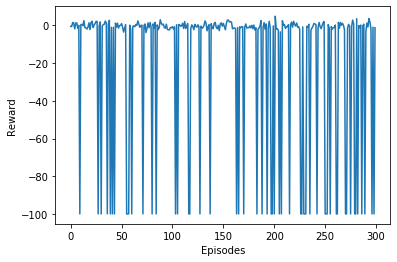

In [52]:
episodes = 300
learning_rate = 0.001
training(episodes, learning_rate)

loss 0.6889948844909668 at epiode 0
reward tensor([-100.]) at epiode 0
loss 0.7211164236068726 at epiode 50
reward tensor([-1.2814]) at epiode 50
loss 0.9474167227745056 at epiode 100
reward tensor([-100.]) at epiode 100
loss 2.900097608566284 at epiode 150
reward tensor([-0.1104]) at epiode 150
loss 0.8119280338287354 at epiode 200
reward tensor([1.6282]) at epiode 200
loss 0.9368258118629456 at epiode 250
reward tensor([1.1971]) at epiode 250
Finished


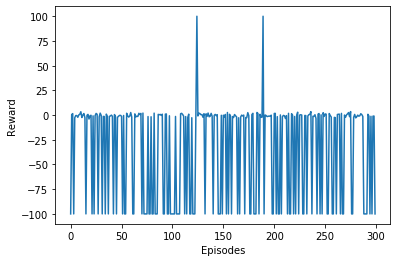

In [53]:
episodes = 300
learning_rate = 0.0001
training(episodes, learning_rate)

In [ ]:
# Why is it currently so bad? How to tweak controls to get success..

# Test the Trained Model

In [32]:
max_steps = 300
env.reset()

for episode in range(5):
    state = env.reset()
    step = 0
    done = False
    print("****************************************************")
    print("EPISODE ", episode)

    for step in range(max_steps):
        # Take the action (index) that have the maximum expected future reward given that state
        
        # Why's no grad not working..
        #with torch.no_grad:
        state_tensor = torch.tensor([state]).to(dtype= torch.float)
        action = Qnet.Forward(state_tensor).max(1)[1].view(1, 1)
        
        new_state, reward, done, info = env.step(action.item())
        env.render()
        
        if done:
            # Here, we decide to only print the last state (to see if our agent is on the goal or fall into an hole)
            env.render()
            print(reward)
            
            # We print the number of step it took.
            print("Number of steps", step)
            break
        state = new_state
env.close()

****************************************************
EPISODE  0
-100
Number of steps 62
****************************************************
EPISODE  1
-100
Number of steps 90
****************************************************
EPISODE  2
-100
Number of steps 70
****************************************************
EPISODE  3
-100
Number of steps 89
****************************************************
EPISODE  4
-100
Number of steps 59


In [ ]:
# Experiements with different settings

# A set up to allow automated testing of different settings.


